## Lecture 12

#### Announcements
* Homework self-reflection due tonight
* Midterm exam wrapper due Sunday night
* P2 survey was not posted, but it is now. Please fill it out by tonight (artifact deadline)


#### Goals
* TODO

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

#### Outline

* Rectified stereo:

  * depth from disparity reduces stereo vision to the correspondence problem

  * assumed a simple case: this is the **rectified case** where (assumptions)

  * correspondence - sounds familiar, but now it's dense. some metrics:

    * SSD - sum of squared differences
    * SAD - sum of absolute differences
    * CC - cross-correlation: filter the right scanline with the left patch; where product is highest, call it a match; in practice, use NCC instead:
    * NCC - normalized cross-correlation: standardize (subtract mean, divide by std) patches before multiplication to add invariance to photometric changes

  * The **cost volume**: given a matching cost c:

    ```
    for i in rows:
      for j in columns:
        for d in disparities:
          C[i, j, d] = c(img1[i,j], img2[i,j+d])
    ```

    (note that c will usually look at a patch around img[i,j])

In [2]:
left = util.imread_grayfloat("../data/flowers_left.png")
right = util.imread_grayfloat("../data/flowers_right.png")

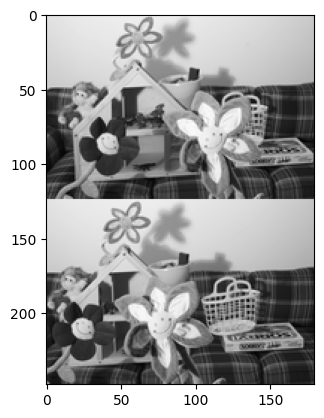

In [3]:
util.imshow_gray(np.vstack((left, right)))

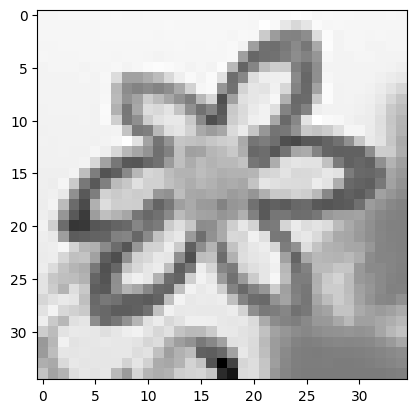

In [4]:
# patch = left[115:125, 205:215]
# patch = left[55:61, 102:107]
patch = left[0:35, 45:80]

util.imshow_gray(patch)

In [6]:
def fast_filter(img, filter):
    return cv2.filter2D(img, -1, filter)

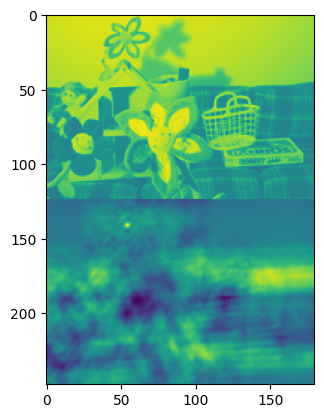

In [7]:
kernel = patch - patch.mean()
xcorr_out = fast_filter(right-right.mean(), patch-patch.mean())
plt.imshow(np.vstack([right, xcorr_out/xcorr_out.max()]))

100%|█████████████████████████████████████████████████████████████| 112/112 [00:10<00:00, 10.34it/s]


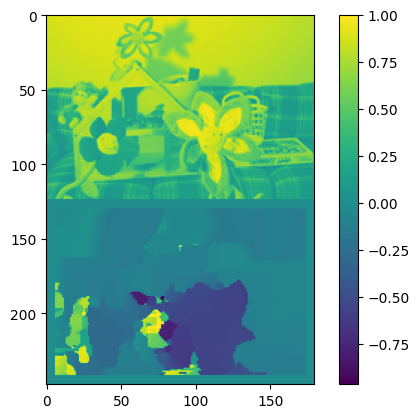

In [19]:
import tqdm

def ncc_cost(left_patch, right_patch):
    return ((left_patch - left_patch.mean()) / left_patch.std() * 
        (right_patch - right_patch.mean()) / right_patch.std()).sum()

def ssd_cost(left_patch, right_patch):
    return np.sum((left_patch - right_patch)**2)

def sad_cost(left_patch, right_patch):
    return np.sum(np.abs(left_patch - right_patch))

H, W = left.shape
window = 13
hw = window // 2

disparity_img = np.zeros_like(left)

disparity_limit = 60


for i in tqdm.tqdm(range(hw, H-hw)):
    low_i = i-hw
    high_i = i+hw+1
    for j in range(hw, W-hw):
        low_j = j-hw
        high_j = j+hw+1
        left_patch = left[low_i:high_i, low_j:high_j]
        costs = 1e5 * np.ones((disparity_limit*2+1))
        for d in range(-disparity_limit, disparity_limit+1): # disparities
            if 0 <= low_j+d and high_j+d <= W:
                right_patch = right[low_i:high_i, low_j+d:high_j+d]
                costs[disparity_limit + d] = ssd_cost(left_patch, right_patch)
        disparity_img[i,j] = np.argmin(costs) - disparity_limit

plt.imshow(np.vstack([left, disparity_img/60]))
plt.colorbar()

### Intrinsics, Extrinsics, Camera Matrix

In [91]:
np.set_printoptions(suppress=True) # suppress scientific notation

In [21]:
points = np.array([
    [0, 0, -200],
    [-20, 50, -200],
    [-100, 100, -200]
], dtype=np.float64).T
points

array([[   0.,  -20., -100.],
       [   0.,   50.,  100.],
       [-200., -200., -200.]])

Suppose a camera is in canonical pose - that is, COP is at world origin, the optical axis runs along the negative z axis, and the projection plane is oriented with going right and

going up in image space. The focal length of the camera is 100 (this is measured in pixels), and the height and width of the image are also 100. Find the image coordinates (i.e., pixel coordinates that correspond to indices into a numpy array) of the following three 3D points:

    Point 1: 

Point 2: Point 3: Keep in mind that in numpy arrays, the origin is at the top left and goes down.

In [29]:
# HW 2: fill in your intrinsics matrix here:
K = np.array([
    [-100, 0, 50],
    [0, 100, 50],
    [0,   0,  1]
], dtype=np.float64)

# HW 3: verify that K @ points yields the expected pixel coordiantes
points_img = K @ points
points_img = points_img / points_img[2,:]
points_img

array([[50., 40., -0.],
       [50., 25., -0.],
       [ 1.,  1.,  1.]])

In [ ]:
# HW 5: write down the camera frame matrix 
cam_center = np.array([200, 0, -200], dtype=np.float64)
frame = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
], dtype=np.float64).T
cam_basis

In [ ]:
# make the 3D points into 3D homogeneous points so they can be translated
points_4d = np.ones((4, 3))
points_4d[:3, :] = points
points_4d

In [ ]:
# HWS 6: Apply the inverse frame matrix to get world coordinates to camera coordinates
pts_cam = np.linalg.inv(Rt) @ points_4d
pts_cam /= pts_cam[3,:]
pts_cam

In [ ]:
# make the intrinsics 3x4 so it drops the 4th dimension
K4d = np.zeros((3, 4))
K4d[:3,:3] = K
K4d

In [ ]:
# HW7: find the final pixel locations of the points in the transformed camera
points_img = K4d @ pts_cam
points_img /= points_img[2,:]
print(points_img)